In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

if os.path.isdir("../notebooks/"):
    os.chdir("..")

In [3]:
import json
import random
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim.models as gm
from tqdm import tqdm

from badseeds import utils, seedbank, metrics

plt.rcParams["font.family"] = "serif"

In [4]:
# path to config json file containing paths to datasets. change if necessary
CONFIG_PATH = "./config.json"

In [5]:
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)

In [6]:
# for replicability
np.random.seed(42)
random.seed(42)

## Models and Data

### Models

In [7]:
embeddings_dir = os.path.join(
    config["models"]["dir_path"], config["models"]["wiki_subpath"]["10"]
)

In [8]:
models = []
for file in tqdm(os.listdir(embeddings_dir)):
    if file.endswith(".kv"):
        models.append(gm.KeyedVectors.load(os.path.join(embeddings_dir, file)))

100%|██████████████████████████████████████████████████| 40/40 [00:08<00:00,  4.85it/s]


### Data

#### Gathered Seed Sets

In [9]:
seeds = seedbank.seedbanking(config["seeds"]["dir_path"] + "seeds.json", index=False)

In [10]:
gathered_seeds = seeds["Seeds"]

In [11]:
highlighted_ids = {
    "names": ["white_names-Knoche_et_al_2019", "black_names-Knoche_et_al_2019"],
    "roles": ["caucasian_roles-Manzini_et_al_2019", "black_roles-Manzini_et_al_2019"],
}

In [12]:
seeds[seeds["Seeds ID"].isin(highlighted_ids["names"])]["Seeds"]

137    [adam, chip, harry, josh, roger, alan, frank, ...
138    [alonzo, jamel, lerone, percell, theo, alphons...
Name: Seeds, dtype: object

In [13]:
seeds[seeds["Seeds ID"].isin(highlighted_ids["roles"])]["Seeds"]

48        [slave, musician, runner, criminal, homeless]
49    [manager, executive, redneck, hillbilly, leade...
Name: Seeds, dtype: object

##### Gathered Seed Set Pairs

In [14]:
pair_df = pd.read_csv(config["pairs"]["dir_path"] + "seed_set_pairings.csv")

#### Generated Seed Sets

In [15]:
# 50 generated seed sets of size 25
generated_seeds = [
    utils.generate_seed_set(model, n=24) for model in tqdm(random.choices(models, k=50))
]

100%|██████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.51it/s]


## Processing

### Embedding

In [16]:
gathered_seeds_embeddings = [
    utils.get_embeddings(seed_set, models, query_strat="average")
    for seed_set in gathered_seeds
]

In [17]:
generated_seeds_embeddings = [
    utils.get_embeddings(seed_set, models, query_strat="average")
    for seed_set in generated_seeds
]

### Pairing

#### Gathered Seed Sets

In [18]:
pair_ids = [list(x) for x in pair_df.to_records(index=False)]

In [19]:
pair_idxs = [seeds[seeds["Seeds ID"].isin(pair)].index.to_list() for pair in pair_ids]

In [20]:
gathered_emb_pairs = [
    [gathered_seeds_embeddings[i], gathered_seeds_embeddings[j]] for (i, j) in pair_idxs
]

#### Generated Seed Sets

In [21]:
generated_emb_pairs = list(itertools.combinations(generated_seeds_embeddings, 2))

### PCA Explained Variance

#### Gathered Seed Sets

In [22]:
gathered_pca_models = [
    metrics.do_pca_embeddings(set_a, set_b, 3)
    for (set_a, set_b) in (gathered_emb_pairs)
]

In [23]:
gathered_exp_var = [
    model.explained_variance_ratio_[0] if model is not None else np.nan
    for model in gathered_pca_models
]

#### Generated Seed Sets

In [24]:
generated_pca_models = [
    metrics.do_pca_embeddings(set_a, set_b, 3)
    for (set_a, set_b) in (generated_emb_pairs)
]

In [25]:
generated_exp_var = [
    model.explained_variance_ratio_[0] if model is not None else np.nan
    for model in generated_pca_models
]

### Set Similarity

In [26]:
gathered_set_sim = [
    metrics.set_similarity(set_a, set_b, True)
    for (set_a, set_b) in (gathered_emb_pairs)
]

In [27]:
generated_set_sim = [
    metrics.set_similarity(set_a, set_b, True)
    for (set_a, set_b) in (generated_emb_pairs)
]

### Additional Processing

In [28]:
# linear fit of generated seed data
gen_coef = np.polyfit(generated_set_sim, generated_exp_var, 1)
gen_poly1d_fn = np.poly1d(gen_coef)

## Plotting

In [29]:
names_idx = pair_df[pair_df["ID_A"] == "white_names-Knoche_et_al_2019"].index.to_list()[
    0
]
roles_idx = pair_df[
    pair_df["ID_B"] == "caucasian_roles-Manzini_et_al_2019"
].index.to_list()[0]

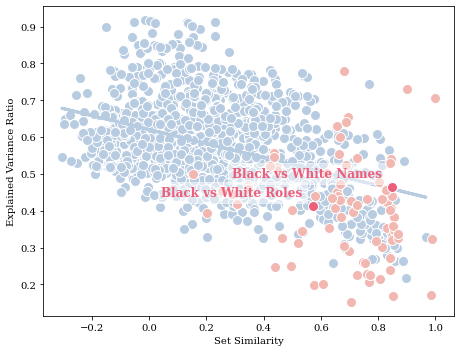

In [30]:
fig, ax = plt.subplots(1, 1)

fig.set_size_inches(w=6.50127, h=5)

# generated
ax.plot(
    generated_set_sim,
    generated_exp_var,
    "o",
    generated_set_sim,
    gen_poly1d_fn(generated_set_sim),
    color="#B8CCE1",
    linewidth=3,
    markersize=10,
    markerfacecolor="#B8CCE1",
    markeredgecolor="white",
)
# gathered
ax.plot(
    gathered_set_sim,
    gathered_exp_var,
    "o",
    markersize=10,
    markerfacecolor="#F1B7B0",
    markeredgecolor="white",
)

highlighted_set_sim = [gathered_set_sim[idx] for idx in [names_idx, roles_idx]]
highlighted_exp_var = [gathered_exp_var[idx] for idx in [names_idx, roles_idx]]
# highlighted gathered
ax.plot(
    highlighted_set_sim,
    highlighted_exp_var,
    "o",
    markersize=10,
    markerfacecolor="#EC5E7B",
    markeredgecolor="white",
)

for i, label in enumerate(["Black vs White Names", "Black vs White Roles"]):
    ax.annotate(
        label,
        (highlighted_set_sim[i], highlighted_exp_var[i]),
        xytext=(-10, 10),
        textcoords='offset points',
        horizontalalignment="right",
        color="#EC5E7B",
        weight="heavy",
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='white')
    )


ax.set_xlabel("Set Similarity")
ax.set_ylabel("Explained Variance Ratio")

fig.set_tight_layout(True)
plt.show()

In [31]:
# save to latex
plt.rc("pgf", texsystem="pdflatex")
fig.savefig("images/fig_5.pgf", bbox_inches="tight")